In [5]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_excel('co2.xlsx')


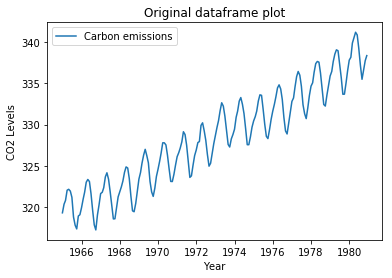

In [6]:
train = data[:168]
test = data[168:]


#Lets rename our columns
data.columns = ['Month','CO2']
""" Now after data cleaning lets have a look at what the data series looks like"""

y = data['CO2']
x = data['Month']

"""Lets plot our original time series"""
plt.figure()
plt.plot(x,y, label='Carbon emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Levels')
plt.title('Original dataframe plot')
plt.legend(loc='upper left')
plt.show()


Text(0,0.5,'CO2')

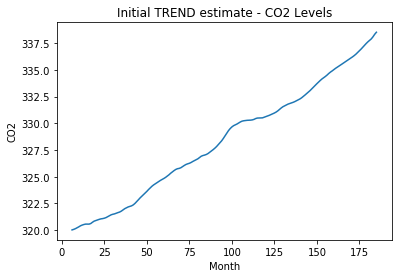

In [7]:
"""The data shows a clear upward trend
    as well as yearly seasonal trend. It
    looks additive"""

"""Now lets decompose our data using additive model"""

T = y.rolling(2, center = True).mean().rolling(12, center = True).mean()
T = T.shift(-1)

plt.figure()
plt.plot(T)
plt.title('Initial TREND estimate - CO2 Levels')
plt.xlabel('Month')
plt.ylabel('CO2')



Text(0,0.5,'CO2')

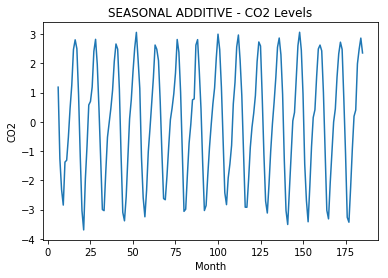

In [8]:
#now calculate seasonality

S_additive = data['CO2'] - T

plt.figure()
plt.plot(S_additive)
plt.title('SEASONAL ADDITIVE - CO2 Levels')
plt.xlabel('Month')
plt.ylabel('CO2')


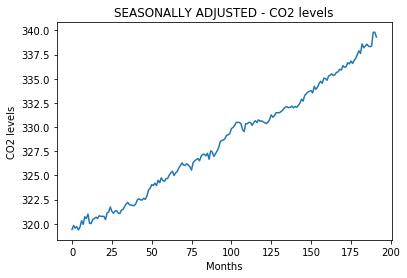

In [9]:
#caculate seasonally adjusted data
years=16
safe_S = np.nan_to_num(S_additive)
safe_S = np.reshape(safe_S,(len(safe_S),1))
monthly_S = np.reshape(safe_S,(years,12))
monthly_avg = np.mean(monthly_S[1:-1], axis=0)
tilled_avg = np.tile(monthly_avg, years)
seasonally_adjusted = data['CO2'] - tilled_avg
plt.figure()
plt.plot(seasonally_adjusted)
plt.title('SEASONALLY ADJUSTED - CO2 levels')
plt.xlabel('Months')
plt.ylabel('CO2 levels')
plt.show(block=False)


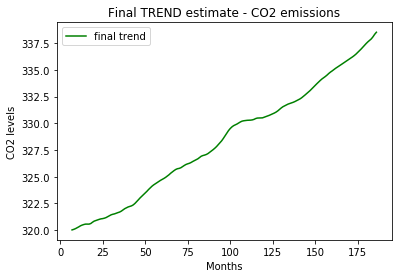

In [10]:
#caculate final trend estimation
T_final = seasonally_adjusted.rolling(2,center=True).mean().rolling(12, center = True).mean()
plt.figure()
plt.plot(T_final, color='g', label='final trend')
#plt.plot(T)
plt.title('Final TREND estimate - CO2 emissions')
plt.xlabel('Months')
plt.ylabel('CO2 levels')
plt.legend()
plt.show(block=False)


C:\Users\Fawad\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


'The errors seem to be all random suggesting \n    no residue that is left of cycle'

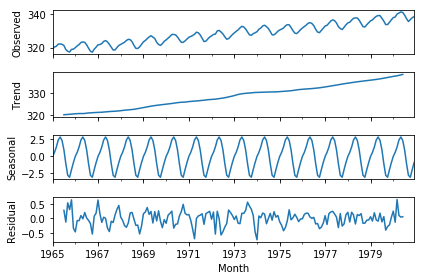

In [11]:

from statsmodels.tsa.seasonal import seasonal_decompose

"""We can use another built in library to decompose our data"""

#To do that we need the dataframe in datatime stamp 
#data['Month'] = pd.to_datetime(data['Month'])

#lets also set month as index
data.set_index('Month',inplace=True)

decomposition = seasonal_decompose(data['CO2'], model="additive", freq=12)  

decomposition.plot()

"""The errors seem to be all random suggesting 
    no residue that is left of cycle"""


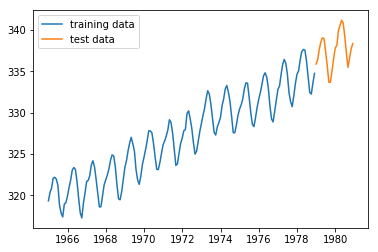

In [12]:
train_i = data[:168]
test_i = data[168:]


plt.figure()
plt.plot(x[:168],train_i, label= 'training data')
plt.plot(x[168:], test_i, label= 'test data')
plt.legend()



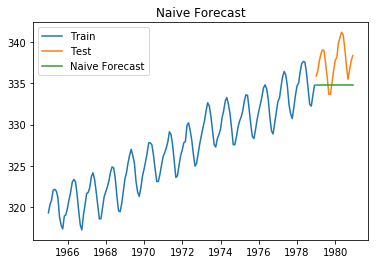

In [13]:
"""Lets now create our baseline model- Naive"""

#lets create a new variable to store all our forecast values
y_hat = test_i.copy()
y_train_list = pd.Series.tolist(y[:168])

#The naive model assumes all values after yt to be equal to yt-1
y_t = y_train_list[len(y_train_list)-1]

#Now lets create a column called 'naive' to store all our values
y_hat['naive'] = y_t

plt.figure(figsize=(6,4))
plt.plot(train_i.index, train_i, label='Train')
plt.plot(test_i.index,test_i, label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()


In [14]:
'''Lets calculate the error from Naive model'''
from sklearn.metrics import mean_squared_error

rms_naive = np.sqrt(mean_squared_error(y_hat['CO2'], y_hat['naive']))
print('Naive RMSE: %.3f '%  (rms_naive))


mape_naive = np.mean(np.abs((y_hat['CO2'] - y_hat['naive'])/y_hat['CO2'])) * 100
print('Naive MAPE: %.3f %%'%  (mape_naive))




Naive RMSE: 3.462 
Naive MAPE: 0.883 %


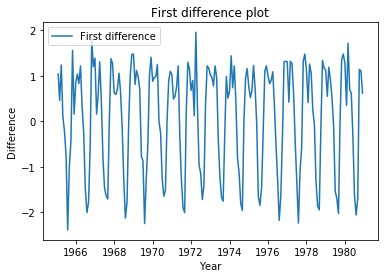

In [15]:
"""Now lets try our second model - ARIMA"""

#The condition of arima is the data should be stationary so lets make our data
#stationary
co2 = pd.read_excel('co2.xlsx', header=0, parse_dates=[0], dayfirst = True, index_col=0, squeeze = True)

data['First difference'] = co2 - co2.shift(1)


plt.figure()
plt.plot(x,data['First difference'], label='First difference')
plt.xlabel('Year')
plt.ylabel('Difference')
plt.title('First difference plot')
plt.legend(loc='upper left')
plt.show()


In [16]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as smt

# Store in a function for later use!
def ad_fuller(data):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(data)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF value','p-value','Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("We reject the null hypothesis as there is strong evidence against it. Data is therefore stationary")
    else:
        print("We do not reject the null hypothesis hence indicating it is non-stationary ")



In [17]:
#Lets check stationarity for first difference
        
ad_fuller(data['First difference'].dropna())

""" the adfuller test tells us the data is stationary"""


Augmented Dickey-Fuller Test:
ADF value : -4.750106971676833
p-value : 6.768699865174398e-05
Lags Used : 11
Number of Observations Used : 179
We reject the null hypothesis as there is strong evidence against it. Data is therefore stationary


' the adfuller test tells us the data is stationary'

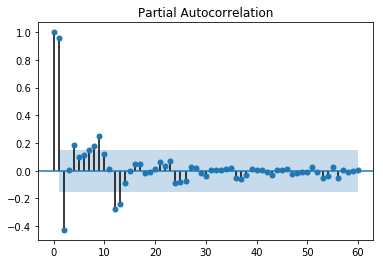

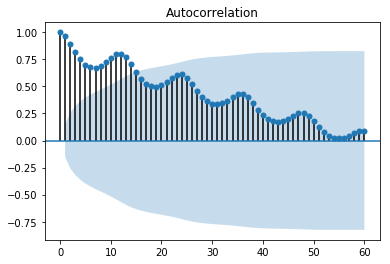

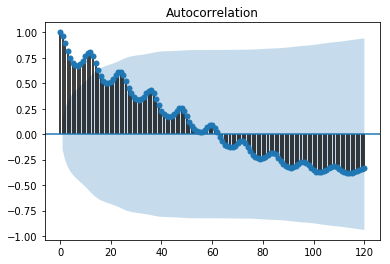

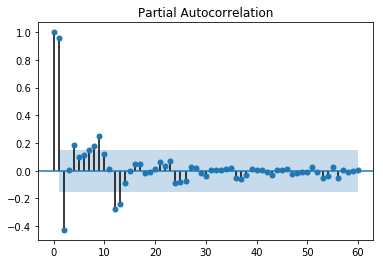

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#Lets plot original data series ACF and PACF plots
#defining train and test data
train_arima = co2[:168]
test_arima = co2[168:]

#drawing ACF and PACF for the data
smt.graphics.tsa.plot_acf(train_arima, lags=60, alpha = 0.05)
smt.graphics.tsa.plot_acf(train_arima, lags=120, alpha = 0.05)
smt.graphics.tsa.plot_pacf(train_arima, lags=60, alpha = 0.05)


In [19]:
from scipy.optimize import brute


def function(order_full, endog):
    converted_order = [int(x) for x in order_full]
    try:
        fit = smt.tsa.statespace.SARIMAX(endog,trend='n', order=order_full[:3], seasonal_order=converted_order[3:]).fit()
        return fit.aic
    except:
        return np.inf

grid = (slice(0, 4, 1), slice(1,2,1), slice(0, 4, 1),slice(1, 4, 1), slice(1,2,1), slice(1, 4, 1), slice(12,13, 1))
optimal = brute(function, grid, args=(train_arima,), finish=None)
optimal_order = [int(x) for x in optimal]

#finding optimal seasonal forecast
optimal_seasonal_model = smt.tsa.statespace.SARIMAX(train_arima, trend='n', order=optimal_order[:3], seasonal_order=optimal_order[3:]).fit()
print(optimal_seasonal_model.summary())
seasonal_forecast = optimal_seasonal_model.predict(start = 168, end= 192, dynamic= False)


C:\Users\Fawad\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Fawad\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Fawad\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Fawad\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\Fawad\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                               CO2    No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(2, 1, 3, 12)   Log Likelihood                 -36.873
Date:                            Tue, 26 Jun 2018   AIC                             89.746
Time:                                    18:44:59   BIC                            114.738
Sample:                                01-01-1965   HQIC                            99.889
                                     - 12-01-1978                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4185      0.209      2.001      0.045       0.008       0.829
ma.L1         -0.6771      0.185   

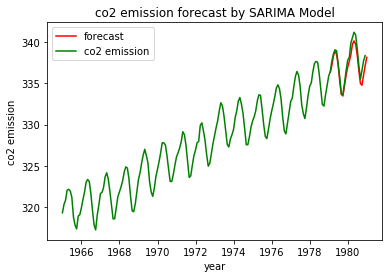

In [20]:
plt.figure()
plt.plot(seasonal_forecast[1:],color='r', label='forecast')
plt.plot(co2, color='g',label='co2 emission')
plt.title('co2 emission forecast by SARIMA Model')
plt.xlabel('year')
plt.ylabel('co2 emission')
plt.legend()
plt.show()


C:\Users\Fawad\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
C:\Users\Fawad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Fawad\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


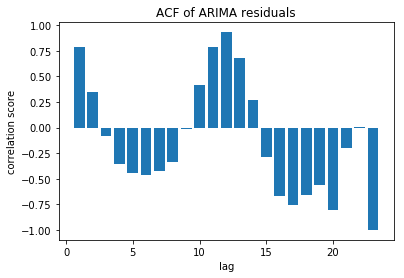

In [21]:
#preparing data for RMSE and MAPE calculation
seasonal_forecast = np.reshape(seasonal_forecast,(len(seasonal_forecast),1))
test_arima = np.reshape(test_arima,(len(test_arima),1))
test_prediction = seasonal_forecast

#preparing residuals ACF
co2 = np.reshape(co2,(len(co2),1))
residuals_arima = co2[167:] - seasonal_forecast
df = pd.DataFrame(residuals_arima)
acf_vals = [df[0].autocorr(i) for i in range(1,30)]

#plotting ACF of residuals
plt.figure()
plt.bar(np.arange(1,30),acf_vals)
plt.title("ACF of ARIMA residuals")
plt.xlabel("lag")
plt.ylabel("correlation score")
plt.show()



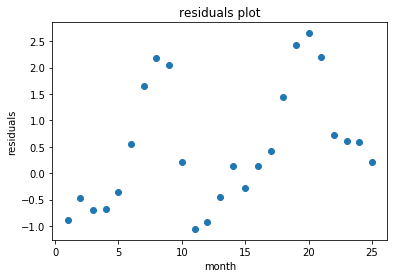

In [22]:
#plotting redisuls 
plt.figure()
plt.title("residuals plot")
X = np.linspace(1, 25,25)
X = np.reshape(X,(25,1))
plt.scatter(X,residuals_arima)
plt.xlabel("month")
plt.ylabel("residuals")
plt.show(block=False)


In [23]:
import math
from sklearn.metrics import mean_squared_error as mse
#calculating RMSE
rmse_arima=math.sqrt(mse(test_arima, seasonal_forecast[:-1]))
print('Sarima RMSE: %.3f RMSE' % (rmse_arima))

#caculating MAPE
mape_arima = np.mean(np.abs((test_arima - seasonal_forecast[:-1])/test_arima)) * 100
print('Sarima MAPE: %.3f %%'%  (mape_arima))



Sarima RMSE: 0.827 RMSE
Sarima MAPE: 0.194 %
